<a href="https://colab.research.google.com/github/asokraju/ml-grinding/blob/master/hands_on_ml/housing_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#imports

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pprint as pp

import os
import urllib
import tarfile
import urllib.request
from zipfile import ZipFile

import scipy
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor

from sklearn.externals import joblib

from pandas.plotting import scatter_matrix

np.random.seed(42)
random.seed(42)

#Data download

In [ ]:
def fetch_zip_data(source_url, local_path, file_name = 'original_file.zip'):
    """
    downloading the zip file from the 'sorce_url' to 'local_path'
    with file name as 'file_name'
    """
    if not os.path.isdir(local_path):
        os.makedirs(local_path)
    local_file = os.path.join(local_path, file_name)
    urllib.request.urlretrieve(download_url, local_file)

    #extracting the contents of the zip file
    with ZipFile(local_file, 'r') as zipObj:
        zipObj.printdir() 
        zipObj.extractall(local_path)
    
    #printing the file list
    files = os.listdir(local_path)
    print(files)

In [ ]:
download_url = 'http://lib.stat.cmu.edu/datasets/houses.zip'
local_path = './datasets/housing'
fetch_zip_data(source_url = download_url, local_path = local_path)
# git_url = "https://raw.githubusercontent.com/ageron/handson-ml/master/" + "datasets/housing" + "/housing.tgz"
# fetch_zip_data(source_url = git_url, local_path = local_path)
# df_original = pd.read_csv(local_path+"/cadata.txt")
# #making a deep copy, we work on the new deep copy
# df = df_original.copy(deep=True)

File Name                                             Modified             Size
cadata.txt                                     1999-11-05 03:05:10      4686855
['cadata.txt', 'original_file.zip']


In [ ]:
col_names = ['medianhousevalue','median_income','housingmedianage','total_rooms','total_bedrooms','population','households','latitude','longitude']

df_original = pd.read_csv(local_path+"/cadata.txt", names = col_names, skiprows=27, header=None, sep = '\s+')
#making a deep copy, we work on the new deep copy
df = df_original.copy(deep=True)

# Data viz


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   medianhousevalue  20640 non-null  float64
 1   median_income     20640 non-null  float64
 2   housingmedianage  20640 non-null  float64
 3   total_rooms       20640 non-null  float64
 4   total_bedrooms    20640 non-null  float64
 5   population        20640 non-null  float64
 6   households        20640 non-null  float64
 7   latitude          20640 non-null  float64
 8   longitude         20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [ ]:
df.describe()

,medianhousevalue,median_income,housingmedianage,total_rooms,total_bedrooms,population,households,latitude,longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,206855.816909,3.870671,28.639486,2635.763081,537.898014,1425.476744,499.539680,35.631861,-119.569704
std,115395.615874,1.899822,12.585558,2181.615252,421.247906,1132.462122,382.329753,2.135952,2.003532
min,14999.000000,0.499900,1.000000,2.000000,1.000000,3.000000,1.000000,32.540000,-124.350000
25%,119600.000000,2.563400,18.000000,1447.750000,295.000000,787.000000,280.000000,33.930000,-121.800000
50%,179700.000000,3.534800,29.000000,2127.000000,435.000000,1166.000000,409.000000,34.260000,-118.490000
75%,264725.000000,4.743250,37.000000,3148.000000,647.000000,1725.000000,605.000000,37.710000,-118.010000
max,500001.000000,15.000100,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,41.950000,-114.310000


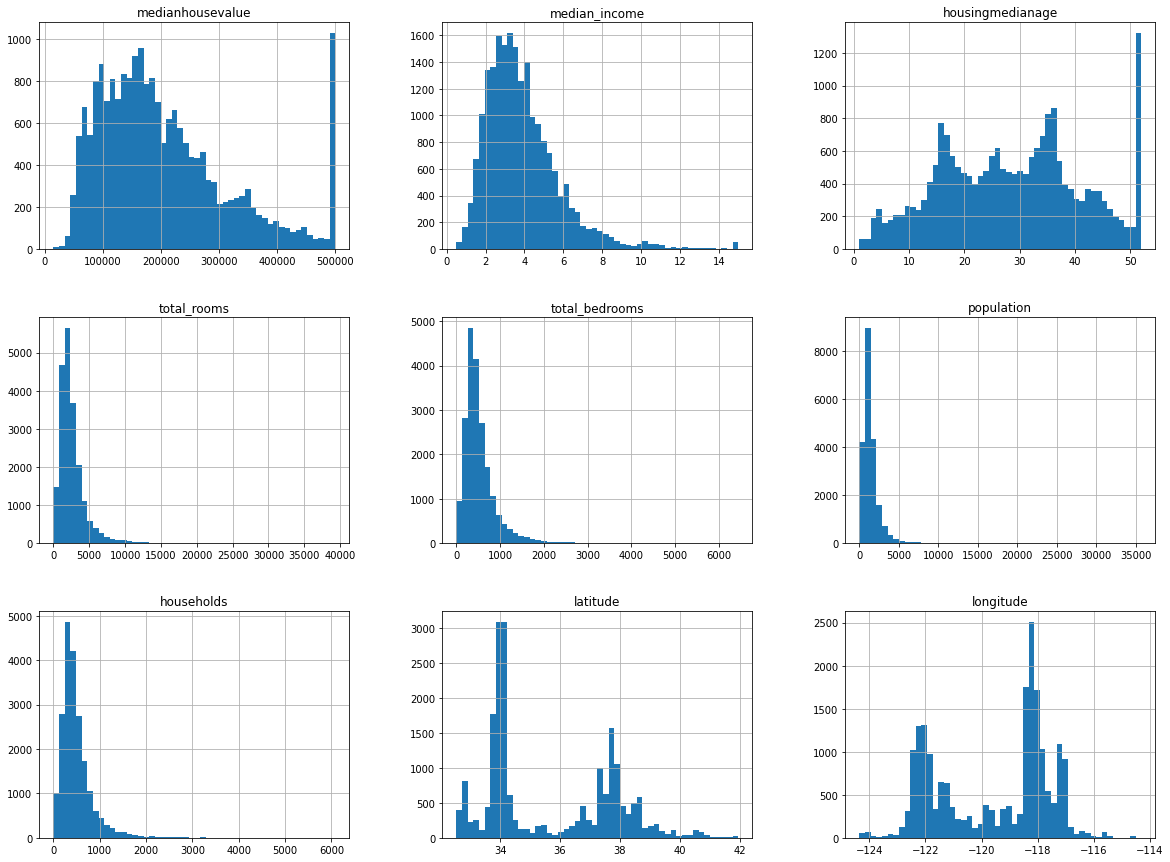

In [ ]:
df.hist(bins=50, figsize=(20,15))
plt.show()

# test train split

##Stratified shuffling


In [ ]:
df['income_cat'] = np.ceil(df['median_income'] / 1.5)
df['income_cat'].where(df['income_cat'] < 5, 5, inplace = True)
df['income_cat'] = df['income_cat'].astype('category')

#df['income_cat_1'] = df['median_income'].apply(lambda x: np.ceil(x/1.5) if np.ceil(x/1.5)<5 else 5)
#df.drop('income_cat_1', 1, inplace=True)
df.head()

,medianhousevalue,median_income,housingmedianage,total_rooms,total_bedrooms,population,households,latitude,longitude,income_cat
0,452600.0,8.3252,41.0,880.0,129.0,322.0,126.0,37.88,-122.23,5.0
1,358500.0,8.3014,21.0,7099.0,1106.0,2401.0,1138.0,37.86,-122.22,5.0
2,352100.0,7.2574,52.0,1467.0,190.0,496.0,177.0,37.85,-122.24,5.0
3,341300.0,5.6431,52.0,1274.0,235.0,558.0,219.0,37.85,-122.25,4.0
4,342200.0,3.8462,52.0,1627.0,280.0,565.0,259.0,37.85,-122.25,3.0


In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['income_cat']):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]
print("test : ",len(strat_test_set),"\ntrain : ",len(strat_train_set))

test :  4128 
train :  16512


In [ ]:
train = strat_train_set.drop('medianhousevalue', axis = 1)
train_labels = strat_train_set['medianhousevalue'].copy()

test = strat_test_set.drop('medianhousevalue', axis = 1)
test_labels = strat_test_set['medianhousevalue'].copy()
train.columns

Index(['median_income', 'housingmedianage', 'total_rooms', 'total_bedrooms',
       'population', 'households', 'latitude', 'longitude', 'income_cat'],
      dtype='object')

#Pipelines

In [ ]:
def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False, kw_args={"add_bedrooms_per_room": True})

In [ ]:
num_attribs = list(train.select_dtypes(include=["number", 'int64', 'float64']))
cat_attribs = list(train.select_dtypes(include=["category",'object']))

In [ ]:
num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
                         ('attribs_adder', attr_adder),
                         ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')),
                         ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
pipeline_preprop = ColumnTransformer([
                                   ('num_pipeline', num_pipeline, num_attribs),
                                   ('cat_pipeline', cat_pipeline, cat_attribs)
])

In [ ]:
param_grid = [
              {'regressor__n_estimators': [3, 10, 30], 
               'regressor__max_features': [2, 4, 6, 8],
               'preprocess__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
               'preprocess__num_pipeline__attribs_adder__kw_args' : [{"add_bedrooms_per_room": True}, {"add_bedrooms_per_room": False}]},
              {'regressor__bootstrap': [False], 
               'regressor__n_estimators': [3, 10], 
               'regressor__max_features': [2, 3, 4],
               'preprocess__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],
               'preprocess__num_pipeline__attribs_adder__kw_args' : [{"add_bedrooms_per_room": True}, {"add_bedrooms_per_room": False}]}
]
rf = Pipeline([
               ('preprocess', pipeline_preprop),
               ('regressor', RandomForestRegressor())
])
pp.pprint(sorted(rf.get_params().keys()))

['memory',
 'preprocess',
 'preprocess__cat_pipeline',
 'preprocess__cat_pipeline__imputer',
 'preprocess__cat_pipeline__imputer__add_indicator',
 'preprocess__cat_pipeline__imputer__copy',
 'preprocess__cat_pipeline__imputer__fill_value',
 'preprocess__cat_pipeline__imputer__missing_values',
 'preprocess__cat_pipeline__imputer__strategy',
 'preprocess__cat_pipeline__imputer__verbose',
 'preprocess__cat_pipeline__memory',
 'preprocess__cat_pipeline__onehot',
 'preprocess__cat_pipeline__onehot__categories',
 'preprocess__cat_pipeline__onehot__drop',
 'preprocess__cat_pipeline__onehot__dtype',
 'preprocess__cat_pipeline__onehot__handle_unknown',
 'preprocess__cat_pipeline__onehot__sparse',
 'preprocess__cat_pipeline__steps',
 'preprocess__cat_pipeline__verbose',
 'preprocess__n_jobs',
 'preprocess__num_pipeline',
 'preprocess__num_pipeline__attribs_adder',
 'preprocess__num_pipeline__attribs_adder__accept_sparse',
 'preprocess__num_pipeline__attribs_adder__check_inverse',
 'preprocess__n

In [ ]:
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train, train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocess',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num_pipeline',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                             

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres['params']):
    print(np.sqrt(-mean_score), params)
grid_search.best_params_

70674.67235770765 {'preprocess__num_pipeline__attribs_adder__kw_args': {'add_bedrooms_per_room': True}, 'preprocess__num_pipeline__imputer__strategy': 'mean', 'regressor__max_features': 2, 'regressor__n_estimators': 3}
60915.71329874833 {'preprocess__num_pipeline__attribs_adder__kw_args': {'add_bedrooms_per_room': True}, 'preprocess__num_pipeline__imputer__strategy': 'mean', 'regressor__max_features': 2, 'regressor__n_estimators': 10}
58194.256692322 {'preprocess__num_pipeline__attribs_adder__kw_args': {'add_bedrooms_per_room': True}, 'preprocess__num_pipeline__imputer__strategy': 'mean', 'regressor__max_features': 2, 'regressor__n_estimators': 30}
64863.531537211165 {'preprocess__num_pipeline__attribs_adder__kw_args': {'add_bedrooms_per_room': True}, 'preprocess__num_pipeline__imputer__strategy': 'mean', 'regressor__max_features': 4, 'regressor__n_estimators': 3}
57291.59263315678 {'preprocess__num_pipeline__attribs_adder__kw_args': {'add_bedrooms_per_room': True}, 'preprocess__num_pi

{'preprocess__num_pipeline__attribs_adder__kw_args': {'add_bedrooms_per_room': True},
 'preprocess__num_pipeline__imputer__strategy': 'most_frequent',
 'regressor__max_features': 8,
 'regressor__n_estimators': 30}

In [ ]:
grid_search.best_estimator_

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_pipeline',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='most_frequent',
                                               

In [ ]:
grid_search.best_estimator_[1]

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
feature_importances = grid_search.best_estimator_[1].feature_importances_

In [ ]:
extra_num_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
extra_cat_attribs = ['income_cat_1', 'income_cat_2', 'income_cat_3', 'income_cat_4', 'income_cat_5']

In [ ]:
attributes = list(train.drop('income_cat', axis = 1).columns) + extra_num_attribs + extra_cat_attribs
sorted(zip(feature_importances, attributes), reverse=True)


[(0.3184345159980119, 'median_income'),
 (0.13865664365677247, 'income_cat_5'),
 (0.11709132055613897, 'bedrooms_per_room'),
 (0.10554763463169196, 'longitude'),
 (0.10318961669714415, 'latitude'),
 (0.06005668216892807, 'housingmedianage'),
 (0.025229128080129337, 'income_cat_4'),
 (0.019618799256743414, 'total_rooms'),
 (0.019546009311800006, 'population'),
 (0.01884055544831321, 'pop_per_hhold'),
 (0.016783888214376496, 'households'),
 (0.016366357682338895, 'rooms_per_hhold'),
 (0.014395352328204632, 'total_bedrooms'),
 (0.01357402909030483, 'income_cat_2'),
 (0.012403374475202246, 'income_cat_3'),
 (0.00026609240389937705, 'income_cat_1')]

#Testing

In [ ]:
final_model = grid_search.best_estimator_
X_test = strat_test_set.drop("medianhousevalue", axis=1)
y_test = strat_test_set["medianhousevalue"].copy()

# X_test_prepared = pd.DataFrame(pipeline_preprop.transform(X_test), columns=attributes)
# final_predictions = final_model.predict(X_test_prepared)
final_predictions = grid_search.best_estimator_.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [ ]:
final_rmse

50892.02799045706

## Confidence interval

In [ ]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([48679.77484821, 52721.32825646])

In [ ]:
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(48679.774848213325, 52721.32825646254)

In [ ]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(48680.39209566318, 52720.758319763496)